# Example: measuring a LSF and slit losses

This notebook demonstrates how to compute and the line spread function for a Sersic profile. We'll also get slit losses for free!  
We will assume a "standard" NIRSpec observing setup, i.e. we will open three shutters to form a slit, and use a 3-point dither pattern.

We need to set up a configuration dictionary that will hold all the parameters that we need to set up our model and specify the details of our observation (location on the MSA, filter/disperser). Let's create a dictionary with some arbitrary default values. We can then view the defaults and edit only the parameters that we care about.

In [1]:
from msafit.model.config import get_default_config

params = get_default_config()

# let's inspect the parameters in the default config dict
print(params.keys())
print("\nparams['instrument']",params["instrument"])
print("\nparams['geometry']=", params["geometry"])
print("\nparams['morph']=", params["morph"])


dict_keys(['geometry', 'instrument', 'morph', 'vfield', 'grid'])

params['instrument'] {'filter': 'F170LP', 'disperser': 'G235M', 'psf_oversampling': 5}

params['geometry']= {'quadrant': 3, 'shutter_i': 183, 'shutter_j': 85, 'shutter_array': '1x3', 'source_shutter': 0, 'psky_x': 0.268, 'psky_y': 0.53}

params['morph']= [{'profile': 'sersic', 'flux': 1.0, 'x0': 0.0, 'y0': 0.0, 'x0_sky': None, 'y0_sky': None, 'r_e': 0.3, 'n': 1.0, 'q': 0.6, 'PA': 90.0}]


We begin by specifying our observing setup. For this example we will look at the prism disperser, for which we first need to edit the params["instrument"] properties.

We will keep the default parameters in params["geometry"]. These describe the quadrant, shutter (i,j), and the shutter configuration: in our case 1x3 shutters, placed in quadrant 3, slitlet (i=183,j=85). We will assume the object is in the middle shutter of these 3, i.e. source_shutter = 0. The parameters psky_x and psky_y describe the angular scale of the slits, the default values are the average of all shutters from Ferruit et al. (2022).

In [2]:
params['instrument']['filter'] = "CLEAR"
params['instrument']['disperser'] = "PRISM"


Let's read in the corresponding PSF library. The PSFs are generated in regular spatial and wavelength intervals. We will use these to set the params["grid"], which are the grids used to evaluate our Sersic profiles on in the next steps.

In [3]:
from msafit.fpa import PSFLib

psfs = PSFLib('1x3_PRISM_Q3_PSFLib.fits')

params["grid"]["x_grid"] = psfs.psf_x
params["grid"]["y_grid"] = psfs.psf_y
params["grid"]["wave_grid"] = psfs.psf_wave


To set up our morphological model, we need to change params["morph"]. This is a list of dictionaries (in this case, only one dictionary), as we can in principle add multiple morphological components. 

We'll change these parameters so that the flux of our Sersic profile integrates to 1 (you'll see why later) and give the source some offset within the shutter. Note that x0 and y0 here are in units of **pitch**, not arcsec, and defined with respect to the centre of the source shutter. If you want to define your shutter offset in arcsec, you will need to set "x0_sky" and "y0_sky" keywords. 

Finally, let's also change the size, Sersic index and axis ratio for fun.



In [4]:
params["morph"][0]["profile"] = "sersic"  # specify the profile
params["morph"][0]["flux"] = 1.           # integrated flux of the Sersic profile
params["morph"][0]["x0"] = 0.0            # offset in dispersion direction (pitch, not arcsec)
params["morph"][0]["y0"] = 0.2            # offset in cross-dispersion direction (pitch, not arcsec)
params["morph"][0]["r_e"] = 0.3           # this is in arcsec
params["morph"][0]["n"] = 1.5             # Sersic index
params["morph"][0]["q"] = 0.4             # axis ratio
params["morph"][0]["PA"] = 90             # rotation angle wrt positive x-axis 
                                          # (note: differs from e.g. the galfit default)

We can now construct our model. We will want to use a model from the MorphOnly parent class of models. The options are: Point, Sersic, Gauss, and UniformIllum. We will use the Sersic model class for this example.

If we give the model a wavelength grid, a model flux cube is generated with dimensions (lambda,y,x).

In [7]:
import numpy as np
from msafit.model import Sersic

# create a model cube I(x,y,lambda)
model = Sersic(params)
model(params["grid"]["wave_grid"])
print(model.data.shape)


(25, 79, 23)


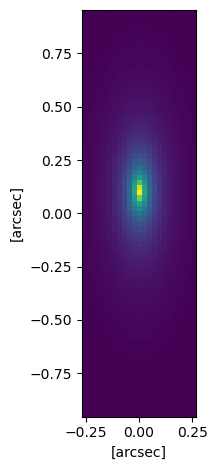

In [8]:
# now plot a slice of the cube

import matplotlib.pyplot as plt

extent = [np.min(params["grid"]["x_grid_sky"]),np.max(params["grid"]["x_grid_sky"]),
         np.min(params["grid"]["y_grid_sky"]),np.max(params["grid"]["y_grid_sky"])]
plt.imshow(model.data[0],origin='lower',extent=extent)
plt.xlabel('[arcsec]')
plt.ylabel('[arcsec]')
plt.tight_layout()
plt.show()


We now have all the ingredients to put our source on the detector. To convolve the model with the PSF library, we use the Spec2D class.

If we set return_fluxes=True we will also measure the total flux on the detector per wavelength slice. Because we set our total flux=1 this means we directly get the throughput (or, 1-path_losses).

As expected, the throughput decreases with wavelength.

In [18]:
from msafit.fpa import Spec2D

spec = Spec2D(params)
throughput = spec.make_spec2d(model,psfs,return_fluxes=True)

print("\ntotal flux on detector:",throughput)



total flux on detector: [0.43340967 0.44164461 0.44508638 0.44458608 0.44168671 0.43714528
 0.43149369 0.42509691 0.41832414 0.41122611 0.40401704 0.39683841
 0.38963223 0.38243037 0.37518473 0.36784396 0.36049213 0.35317934
 0.34587162 0.33857291 0.33130027 0.32412226 0.31703982 0.31005107
 0.30312947]


We can now plot the detectors, and zoom in on some of the individual emission lines.


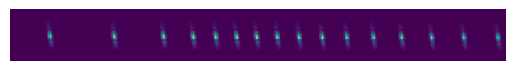

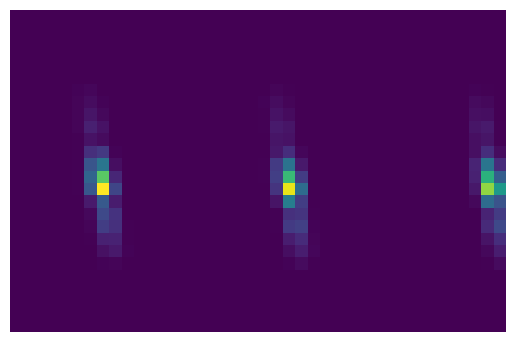

In [19]:
# let's plot some of detector SCA-491 

plt.imshow(spec.spec_491[:,0:250],origin='lower')
plt.axis('off')
plt.show()

plt.imshow(spec.spec_491[:,190:230],origin='lower')
plt.axis('off')
plt.show()

We can now repeat this for the other two nods in our 3-point nodding pattern. Then we collapse our set of spectra along the spatial direction to compute the LSF. The latter steps are all handled in the LSF class. (Note that any 1D spectra created in the process are **not** real 1D spectra, as there is no wavelength calibration nor rectification/regridding)

In [21]:
from msafit.lsf import LSF
from copy import deepcopy

params_2 = deepcopy(params)
params_2["geometry"]["shutter_j"] = params["geometry"]["shutter_j"] - 1
params_2["geometry"]["source_shutter"] = -1
spec_2 = Spec2D(params_2)
spec_2.make_spec2d(model,psfs)
    
params_3 = deepcopy(params)
params_3["geometry"]["shutter_j"] = params["geometry"]["shutter_j"] + 1
params_3["geometry"]["source_shutter"] = 1
spec_3 = Spec2D(params_3)
spec_3.make_spec2d(model,psfs)

# we provide our 3 dithers to the LSF class
# we only provide the wavelengths of interest and corresponding x FPA coordinates once
lsf = LSF([spec,spec_2,spec_3],spec.wl_fpa,spec.x_fpa)
fit_output = lsf.compute_lsf()

The fit_output can be used for plotting. More important is that we can now estimate the LSF anywhere! (at least, anywhere within the wavelength range we defined earlier)

In [22]:
print('resolution at 2.52 micron =', lsf.resolution(2.52e4))
print('dispersion at 1.78 micron =', lsf.dispersion_kms(1.78e4), 'km/s')


resolution at 2.52 micron = 99.68652912944762
dispersion at 1.78 micron = 2286.40294889179 km/s


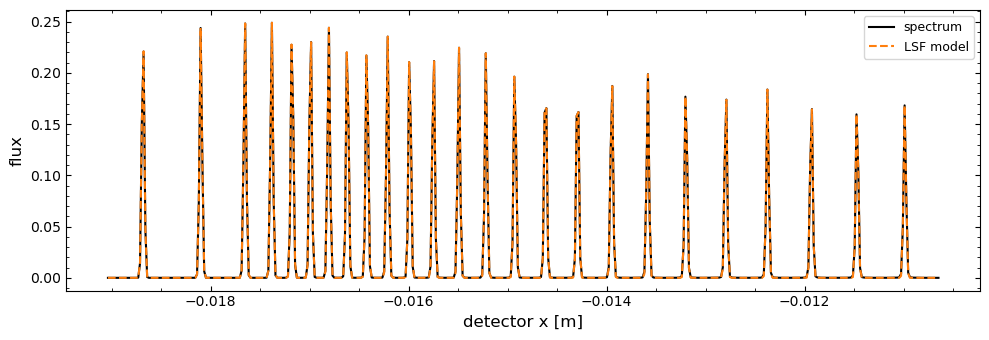

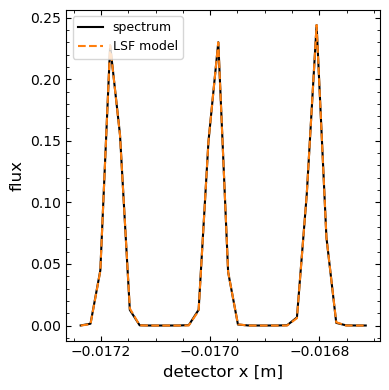

In [28]:
from msafit.lsf.fit_func import gauss_dataset
from matplotlib.ticker import AutoMinorLocator

x1d,spec1d = spec.to_1d()

model_1d = gauss_dataset(fit_output[0].params,0,len(lsf.wl_fpa),x1d)


fig,ax = plt.subplots(1,1,figsize=(10,3.5))

ax.plot(x1d,spec1d,color='k',ls='solid',label='spectrum')
ax.plot(x1d,model_1d,color='C1',ls='--',label='LSF model')
ax.set_xlabel(r"detector x [m]",fontsize=12)
ax.set_ylabel(r"flux",fontsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())		
ax.tick_params(direction='in',which='both',top=True,right=True)
ax.locator_params(nbins=6)
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()


fig,ax = plt.subplots(1,1,figsize=(4,4))

ax.plot(x1d[100:130],spec1d[100:130],color='k',ls='solid',label='spectrum')
ax.plot(x1d[100:130],model_1d[100:130],color='C1',ls='--',label='LSF model')
ax.set_xlabel(r"detector x [m]",fontsize=12)
ax.set_ylabel(r"flux",fontsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())		
ax.tick_params(direction='in',which='both',top=True,right=True)
ax.locator_params(axis='x',nbins=3)
ax.legend(fontsize=9,loc=2)
plt.tight_layout()
plt.show()

Finally, let's compare with what STScI tells us... (https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-dispersers-and-filters)

Quite different!

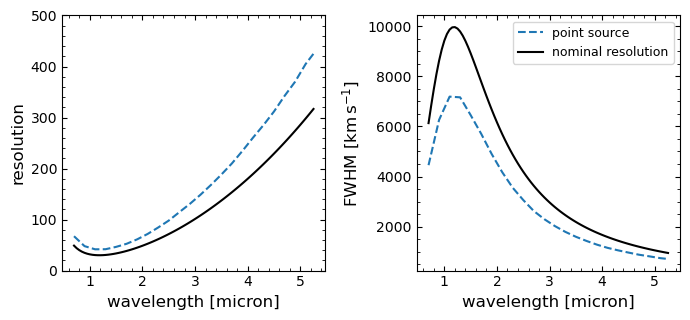

In [37]:
from astropy.table import Table
from scipy.interpolate import interp1d

disp_curve_stsci = Table.read(f'./data/jwst_nirspec_{params["instrument"]["disperser"].lower()}_disp.fits')
fdisp = interp1d(disp_curve_stsci['WAVELENGTH'],disp_curve_stsci['R'],kind='cubic')
wrange = np.arange(0.7,5.3,0.05)*1e4

fig,ax = plt.subplots(1,2,figsize=(7,3.3))

ax[0].plot(wrange*1e-4,lsf.resolution(wrange),color='C0',ls='--',label='point source')
ax[0].plot(wrange*1e-4,fdisp(wrange*1e-4),color='k',ls='solid',label='nominal resolution')
ax[0].set_xlabel(r"wavelength [micron]",fontsize=12)
ax[0].set_ylabel(r"resolution",fontsize=12)
ax[0].set_ylim(0,500)
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())		
ax[0].tick_params(direction='in',which='both',top=True,right=True)
ax[0].locator_params(nbins=6)


ax[1].plot(wrange*1e-4,2*np.sqrt(2*np.log(2)) *lsf.dispersion_kms(wrange),color='C0',ls='--',label='point source')
ax[1].plot(wrange*1e-4,3e5/(fdisp(wrange*1e-4)),color='k',ls='solid',label='nominal resolution')
ax[1].set_xlabel(r"wavelength [micron]",fontsize=12)
ax[1].set_ylabel(r"FWHM [$\rm km\,s^{-1}$]",fontsize=12)
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())		
ax[1].tick_params(direction='in',which='both',top=True,right=True)
ax[1].locator_params(nbins=6)
ax[1].legend(fontsize=9)

plt.tight_layout()
plt.show()